# User Guide
## Examples on how to store and retrieve data using StorageGroup 

In [1]:
from datetime import datetime
import json
import os
import numpy as np
import pandas as pd
import requests
import xarray as xr
from tonik import StorageGroup 

You can define any directory structure within a  storage group. We here use the hierarchy that is common for seismometers which is network, site, sensor, and channel. Data can be stored under each of them. We will start by generating fake spectrogram data and then store that under a channel.

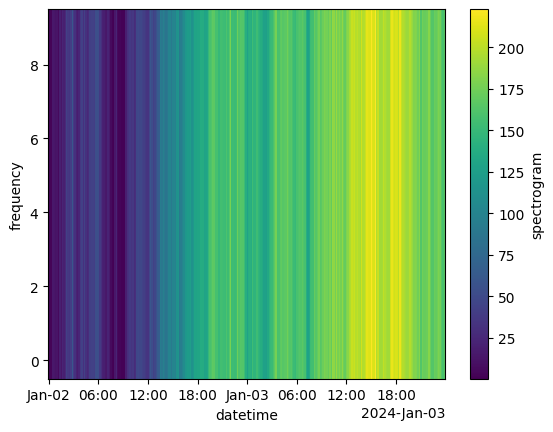

In [2]:
dates = pd.date_range("2024-01-02", freq='10min', periods=288)
data = np.abs(np.cumsum(np.random.normal(0, 8., len(dates))))
data = np.tile(data, (10, 1))
freqs = np.arange(10)
xrd = xr.Dataset({'spectrogram': xr.DataArray(data, coords=[freqs, dates],
                                              dims=['frequency', 'datetime'])})
fig = xrd['spectrogram'].plot()

Now we will store the data under two different sites of the same experiment using the same sensor and channel names for both.

In [3]:
g = StorageGroup('experiment', rootdir='/tmp')
st1 = g.get_store('NET1', 'MDR1', '00', 'HHZ')
st2 = g.get_store('NET1', 'MDR2', '00', 'HHZ')
st1.save(xrd)
st2.save(xrd)
g

Group: experiment
/tmp/experiment
  /tmp/experiment/NET1
    /tmp/experiment/NET1/MDR1
      /tmp/experiment/NET1/MDR1/00
        /tmp/experiment/NET1/MDR1/00/HHZ
    /tmp/experiment/NET1/MDR2
      /tmp/experiment/NET1/MDR2/00
        /tmp/experiment/NET1/MDR2/00/HHZ

Next we want to retrieve the data we just saved. Before retrieving data we have to set the timespan over which we want to retrieve data.

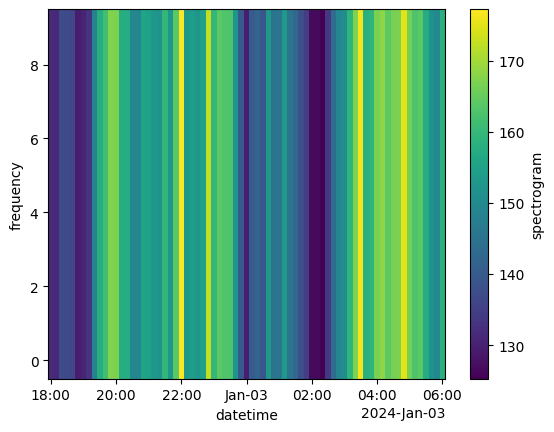

In [4]:
g.starttime = datetime(2024, 1, 2, 18, 0, 0)
g.endtime = datetime(2024, 1, 3, 6, 0, 0)
st = g.get_store('NET1', 'MDR2', '00', 'HHZ')
st('spectrogram').plot()

In [5]:
# Now start the API server by running the following command in a terminal
# tonik_api --rootdir /tmp

Let's first have a look what is available.

In [6]:
url = f"http://localhost:8003/inventory?group={g.name}"
requests.get(url).json()

{'experiment': [{'NET1': [{'MDR1': [{'00': [{'HHZ': ['spectrogram']}]}]},
    {'MDR2': [{'00': [{'HHZ': ['spectrogram']}]}]},
    {'MDR3': ['rsam']},
    {'MDR3name=rsam': []}]}]}

Now let's request the data we just stored.

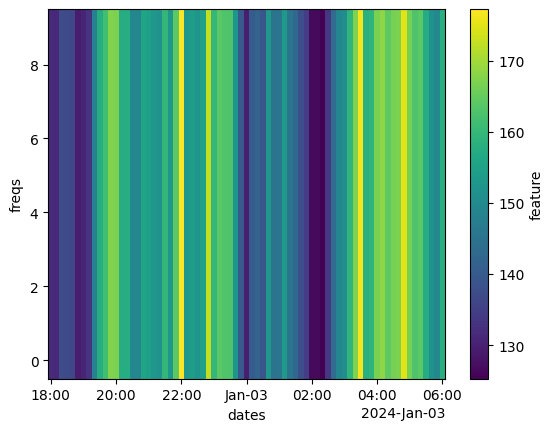

In [7]:
url = "http://localhost:8003/feature?"
url += f"group={g.name}&subdir=NET1&subdir=MDR2&subdir=00&subdir=HHZ&name=spectrogram"
url += f"&starttime={g.starttime.isoformat()}&endtime={g.endtime.isoformat()}" 
spec = pd.read_csv(url, parse_dates=True, index_col=[0, 1], date_format='ISO8601').to_xarray()
spec.transpose('freqs', 'dates')['feature'].plot()

Note that we repeated the `subdir` parameter multiple times. It is important that you pass the subdirs in the order of your directory structure.

## Using pandas instead of xarray

First we'll create some fake data again. Note that we name the feature in the DataFrame and also that we name the index `datetime`. The `save` function uses this information when creating the files on disk. If the dataframe contains multiple features they will be stored in separate files.

<Axes: xlabel='datetime'>

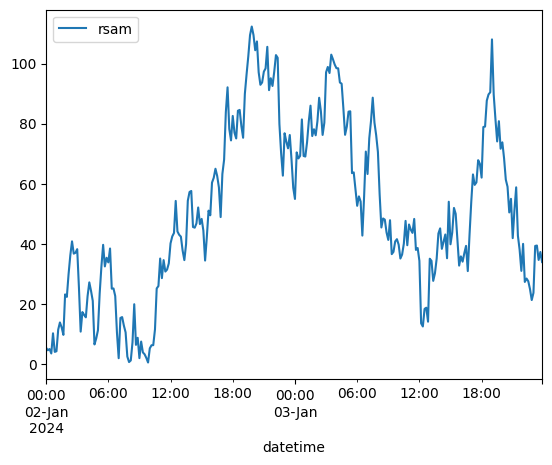

In [8]:
dates = pd.date_range("2024-01-02", freq='10min', periods=288)
data = np.abs(np.cumsum(np.random.normal(0, 8., len(dates))))
df = pd.DataFrame({'rsam': data}, index=dates)
df.index.name = 'datetime'
df.plot()

For illustration, this time we store the data under the site.

In [9]:
st3 = g.get_store('NET1', 'MDR3')
st3.save(df.to_xarray())

<Axes: xlabel='dates'>

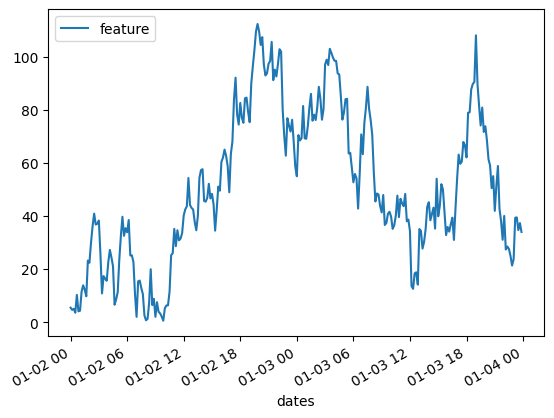

In [10]:
url = "http://localhost:8003/feature?"
url += f"group={g.name}&subdir=NET1&subdir=MDR3&name=rsam"
url += f"&starttime=2024-01-02T00:00:00&endtime=2024-01-04T00:00:00" 
rsam = pd.read_csv(url, parse_dates=True, index_col=0, date_format='ISO8601')
rsam.plot()